In [1]:
### Datos
import pandas as pd
import numpy as np

#Graficos
import matplotlib.pyplot as plt
import seaborn as sns

#Statsmodels
import statsmodels.formula.api as smf
import statsmodels.api as sm


from scipy import stats

#Skelearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics, preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import scipy.cluster.hierarchy as sch

# from yellowbrick.cluster import silhouette_visualizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.tools.tools import add_constant
from scipy.stats import shapiro

# Descripción del problema



# Exploración de los datos

In [2]:
rod = pd.read_excel('../data/rod/train_rod.xlsx')
rod.head()

,leak_dia,leak_distance,pressure,flow_pipe,rod,leak_flow
0,3.5,15.3333,1190,76.752,31.966865,152.279497
1,3.5,7.6667,653,189.540,17.530478,93.460428
2,3.5,7.6667,653,58.729,16.312640,81.364855
3,3.5,7.6667,1016,76.752,26.121132,129.525084
4,3.5,15.3333,1016,189.540,22.906330,127.163212


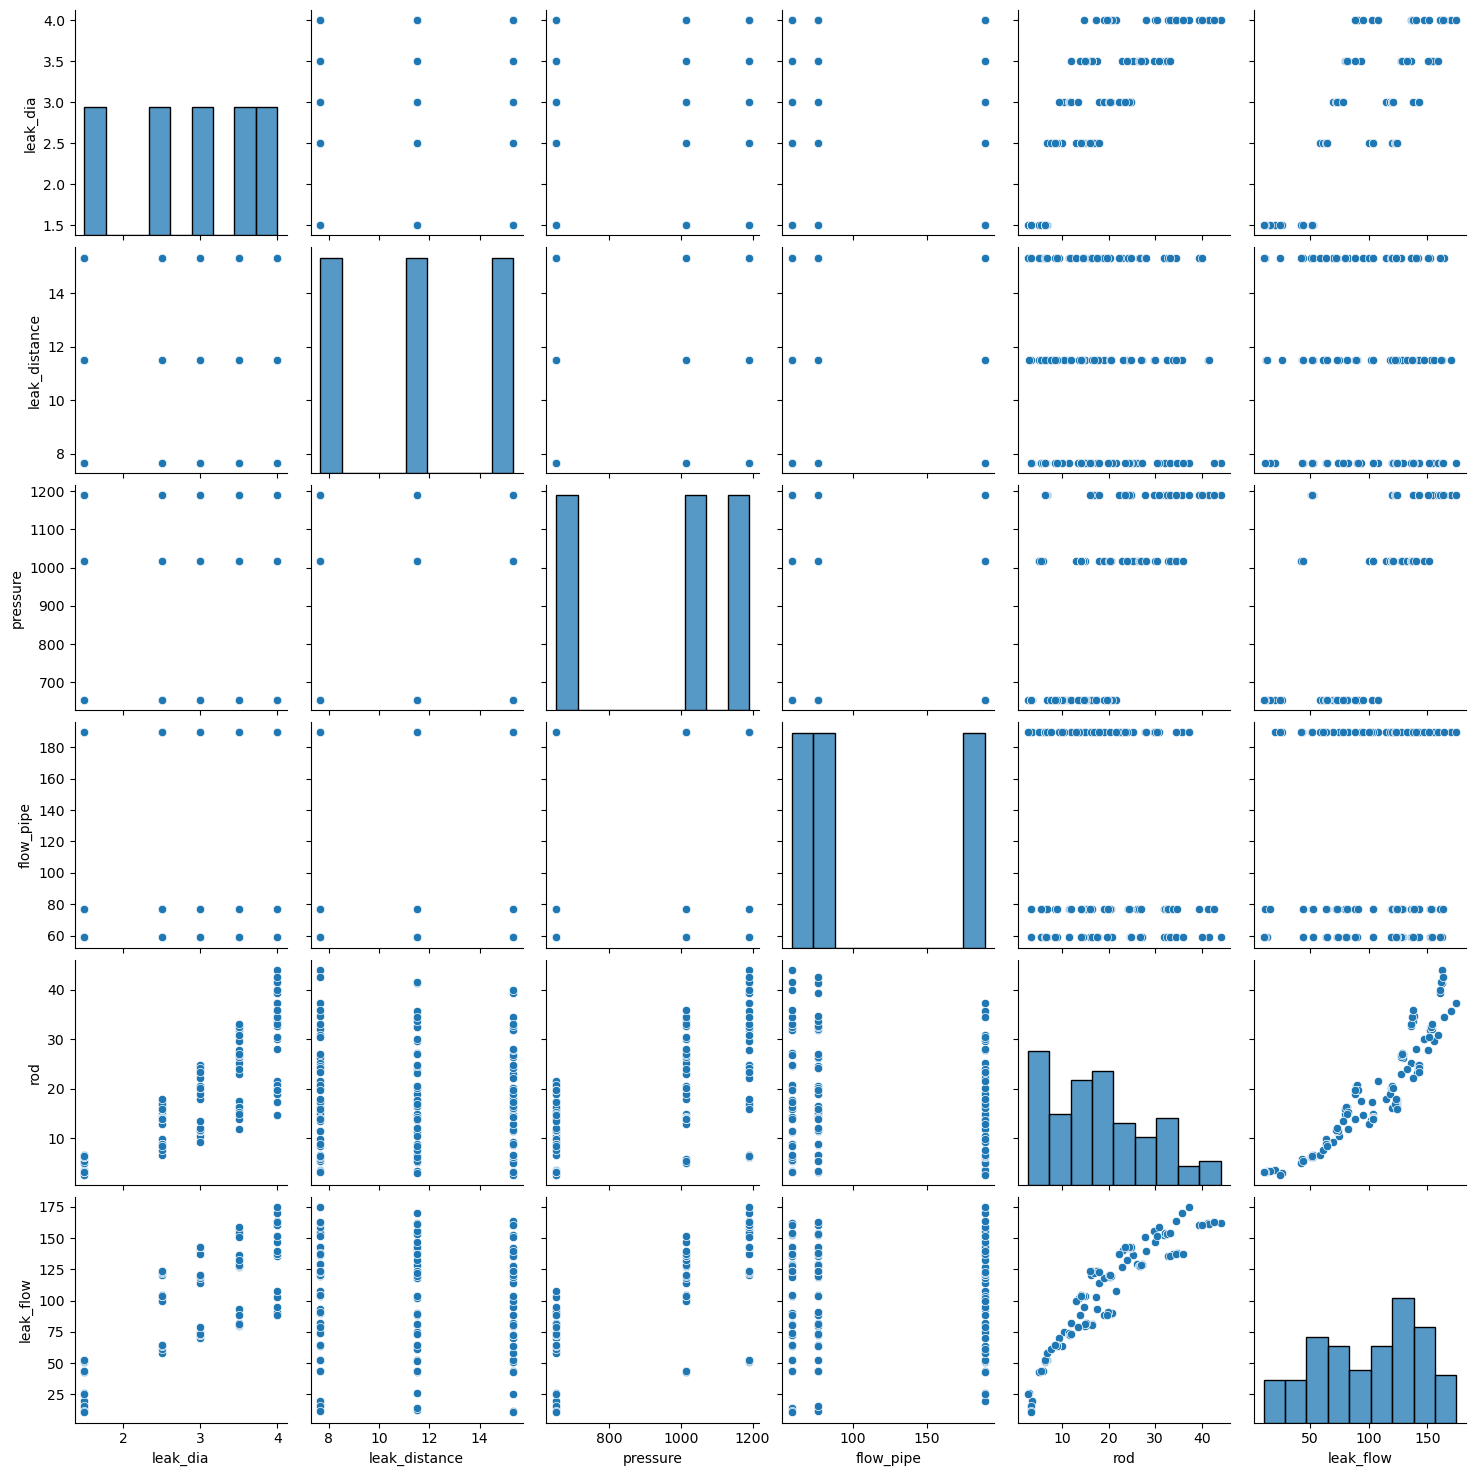

In [3]:
sns.pairplot(rod)

In [4]:
#rod.drop(columns=['ID','leak_flow'], inplace=True)
rod_nor = preprocessing.scale(rod)

Text(0.5, 0, 'Número de clusters')

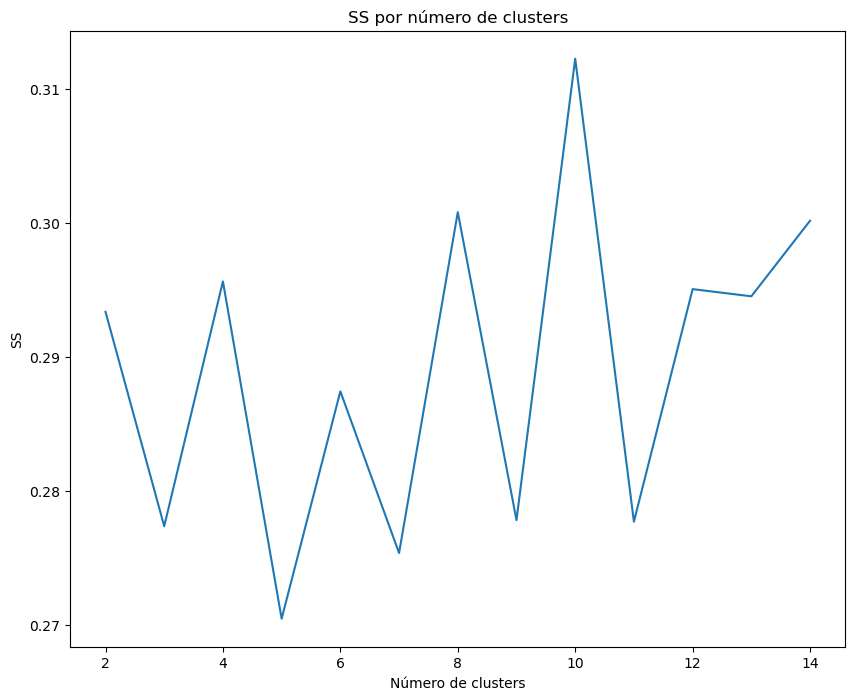

In [5]:
plt.figure(figsize=(10,8))
ss =[]
maxRange = 15
for i in range(2,maxRange):
  kmeans = KMeans(n_clusters=i, init='k-means++')
  kmeans.fit(rod_nor)
  ss.append(silhouette_score(rod_nor, kmeans.labels_))
plt.plot(range(2,maxRange), ss)
plt.title('SS por número de clusters')
plt.ylabel('SS')
plt.xlabel('Número de clusters')

In [6]:
#Escojo un modelo de 2 cluster por tener el mayor ss
kmeans = KMeans(n_clusters=9, init='k-means++')
model = kmeans.fit(rod_nor)

#Guardo los clusters en el rdb recodificado
rod_cluster = rod.copy()
rod_cluster['Cluster'] = model.labels_

In [9]:
rod_cluster.head()

,leak_dia,leak_distance,pressure,flow_pipe,rod,leak_flow,Cluster
0,3.5,15.3333,1190,76.752,31.966865,152.279497,2
1,3.5,7.6667,653,189.540,17.530478,93.460428,5
2,3.5,7.6667,653,58.729,16.312640,81.364855,1
3,3.5,7.6667,1016,76.752,26.121132,129.525084,0
4,3.5,15.3333,1016,189.540,22.906330,127.163212,4


In [10]:
rod_cluster.groupby(['Cluster']).describe()['pressure']

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,20.0,1085.600000,87.456696,1016.0,1016.0,1016.0,1190.0,1190.0
1,24.0,653.000000,0.000000,653.0,653.0,653.0,653.0,653.0
2,14.0,1090.571429,89.358151,1016.0,1016.0,1016.0,1190.0,1190.0
3,18.0,953.000000,230.195313,653.0,653.0,1016.0,1190.0,1190.0
4,12.0,1088.500000,89.597585,1016.0,1016.0,1016.0,1190.0,1190.0
5,12.0,653.000000,0.000000,653.0,653.0,653.0,653.0,653.0
6,12.0,1117.500000,89.597585,1016.0,1016.0,1190.0,1190.0,1190.0
7,14.0,1140.285714,81.572458,1016.0,1059.5,1190.0,1190.0,1190.0
8,9.0,953.000000,237.279898,653.0,653.0,1016.0,1190.0,1190.0


<AxesSubplot: >

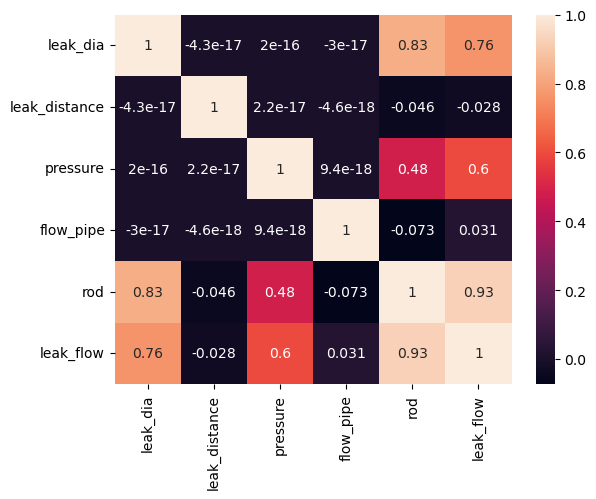

In [11]:
sns.heatmap(rod.corr(), annot=True)

In [12]:
Xtrain, ytrain = rod.drop(columns=["rod",'leak_flow']), rod["rod"]

In [13]:
# Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=123)

# Modeling

El definir el algoritmo idoneo para entender este fenómeno se evaluarán los siguientes algoritmos:

- Regresión lineal
- Arboles de regresión
- Random forest de regresión
- SVM (SVR)

Como validez de una regresión lineal parte de 


## Linear Regression


### Modelos de regresión 1:

In [14]:
# Construir el modelo de regresión lineal con todas las variables
Xtrain_c = sm.add_constant(Xtrain)
RL_total = sm.OLS(ytrain, Xtrain_c).fit()
print(RL_total.summary())

                            OLS Regression Results                            
Dep. Variable:                    rod   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     417.6
Date:                Fri, 08 Mar 2024   Prob (F-statistic):           3.96e-73
Time:                        03:12:48   Log-Likelihood:                -332.02
No. Observations:                 135   AIC:                             674.0
Df Residuals:                     130   BIC:                             688.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -29.5944      1.711    -17.294

In [15]:
RL_total.rsquared

0.927786119258207

In [16]:
RL_total.resid

0      2.453045
1      0.477360
2     -2.481522
3     -0.644113
4     -1.170493
         ...   
130    0.454049
131   -2.528184
132   -2.871762
133   -2.083435
134   -4.648046
Length: 135, dtype: float64

In [17]:
RL_total.params

const           -29.594440
leak_dia         10.167672
leak_distance    -0.154861
pressure          0.022620
flow_pipe        -0.013310
dtype: float64

In [18]:
RL_total.fittedvalues

0      29.513820
1      17.053118
2      18.794162
3      26.765245
4      24.076823
         ...    
130     8.032861
131    16.597573
132    16.837452
133    16.003944
134    20.533406
Length: 135, dtype: float64

### Modelos de regresión 2:

In [19]:
# Construir el modelo de regresión lineal
RL_dp = sm.OLS(ytrain, Xtrain_c.drop(columns=["leak_distance"])).fit()
print(RL_dp.summary())

                            OLS Regression Results                            
Dep. Variable:                    rod   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     543.8
Date:                Fri, 08 Mar 2024   Prob (F-statistic):           1.02e-73
Time:                        03:12:48   Log-Likelihood:                -333.97
No. Observations:                 135   AIC:                             675.9
Df Residuals:                     131   BIC:                             687.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -31.3753      1.463    -21.441      0.0

In [20]:
anova_result = sm.stats.anova_lm(RL_dp, RL_total)
print(anova_result)

# Interpreta el resultado de ANOVA
if anova_result['Pr(>F)'][1] < 0.05:
    print("Hay una diferencia significativa entre los dos modelos.")
else:
    print("No hay una diferencia significativa entre los dos modelos, por tanto, se elige el modelo restringido")

   df_resid          ssr  df_diff    ss_diff         F   Pr(>F)
0     131.0  1113.344027      0.0        NaN       NaN      NaN
1     130.0  1081.628468      1.0  31.715559  3.811866  0.05304
No hay una diferencia significativa entre los dos modelos, por tanto, se elige el modelo restringido


Con lo anterior, 

In [21]:
# Se excluye del resto desl análisis esta variable.
Xtrain = Xtrain.drop(columns=["leak_distance"])

### Model adequacy checking

El procedimeinto a continuación 

#### Análisis de residuos

La media de los residuos: 7.239719934659661e-12


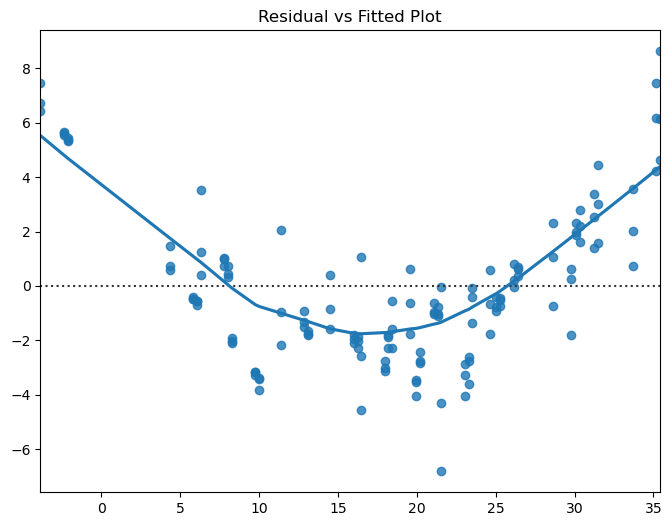

In [22]:
print("La media de los residuos: {}".format(RL_dp.resid.mean()))
plt.figure(figsize=(8, 6))
sns.residplot(x=RL_dp.fittedvalues, y=RL_dp.resid, lowess=True)
plt.title('Residual vs Fitted Plot')
plt.show()

In [23]:
# Realiza la prueba de Breusch-Pagan
_, p_value, _, _ = het_breuschpagan(RL_dp.resid, Xtrain_c)
print(f'p-value for Breusch-Pagan test: {p_value}')
if p_value <= 0.005:
    print("Hay evidencia de heterocedasticidad (varianza no constante).")
else:
    print("No hay suficiente evidencia para sugerir heterocedasticidad (varianza constante).")

p-value for Breusch-Pagan test: 0.4449876816740447
No hay suficiente evidencia para sugerir heterocedasticidad (varianza constante).


<Figure size 800x600 with 0 Axes>

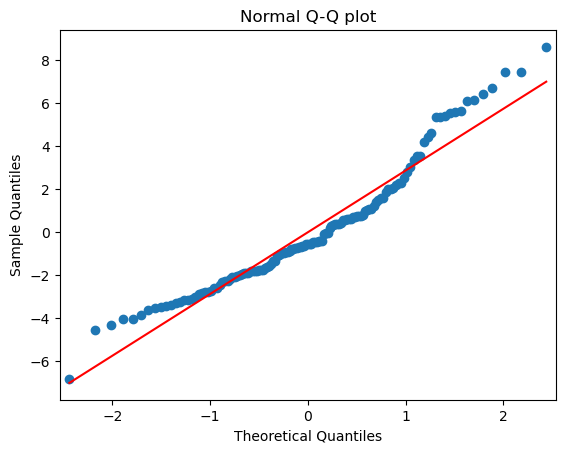

In [24]:
# 2. Normalidad de los residuos
plt.figure(figsize=(8, 6))
sm.qqplot(RL_dp.resid, line='s')
plt.title('Normal Q-Q plot')
plt.show()

In [25]:
print('Normalidad (shapiro-test):', stats.shapiro(RL_dp.resid))

Normalidad (shapiro-test): ShapiroResult(statistic=0.9440420866012573, pvalue=2.89882518700324e-05)


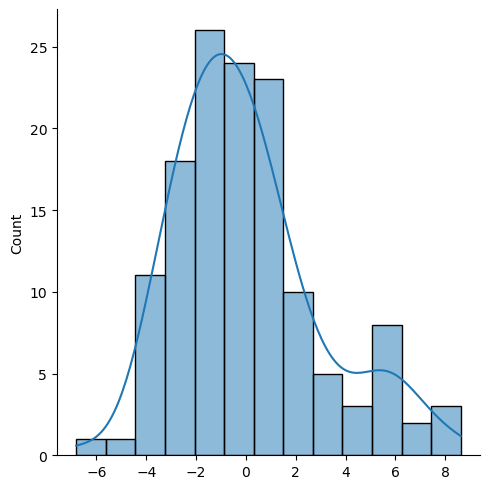

In [26]:
sns.displot(RL_dp.resid, kde=True);

In [27]:
poly = PolynomialFeatures(degree=2)
Xtrain_poly = poly.fit_transform(Xtrain)

In [28]:
# Construir el modelo de regresión lineal
RL_ajust = sm.OLS(ytrain, Xtrain_poly).fit()
print(RL_ajust.summary())

                            OLS Regression Results                            
Dep. Variable:                    rod   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     1473.
Date:                Fri, 08 Mar 2024   Prob (F-statistic):          2.62e-122
Time:                        03:12:48   Log-Likelihood:                -193.99
No. Observations:                 135   AIC:                             408.0
Df Residuals:                     125   BIC:                             437.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.7765      3.337      2.930      0.0

La media de los residuos: -2.1362739791133782e-09


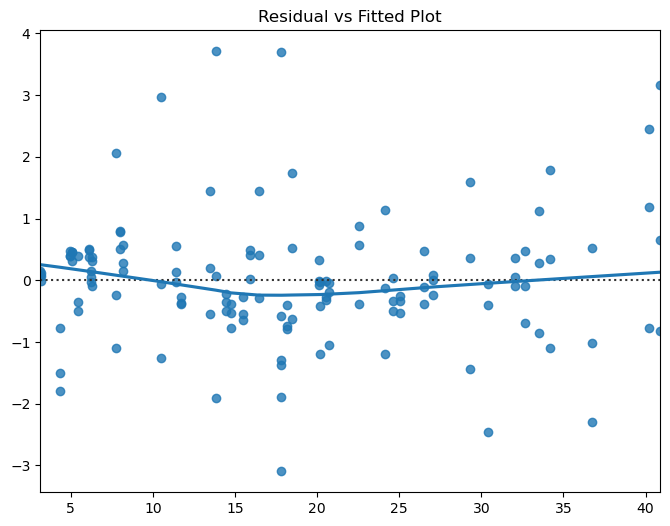

In [29]:
print("La media de los residuos: {}".format(RL_ajust.resid.mean()))
plt.figure(figsize=(8, 6))
sns.residplot(x=RL_ajust.fittedvalues, y=RL_ajust.resid, lowess=True)
plt.title('Residual vs Fitted Plot')
plt.show()

In [30]:
# Realiza la prueba de Breusch-Pagan
_, p_value, _, _ = het_breuschpagan(RL_ajust.resid, Xtrain_poly)
print(f'p-value for Breusch-Pagan test: {p_value}')
if p_value <= 0.005:
    print("Hay evidencia de heterocedasticidad (varianza no constante).")
else:
    print("No hay suficiente evidencia para sugerir heterocedasticidad (varianza constante).")

p-value for Breusch-Pagan test: 2.545711504100236e-07
Hay evidencia de heterocedasticidad (varianza no constante).


<Figure size 800x600 with 0 Axes>

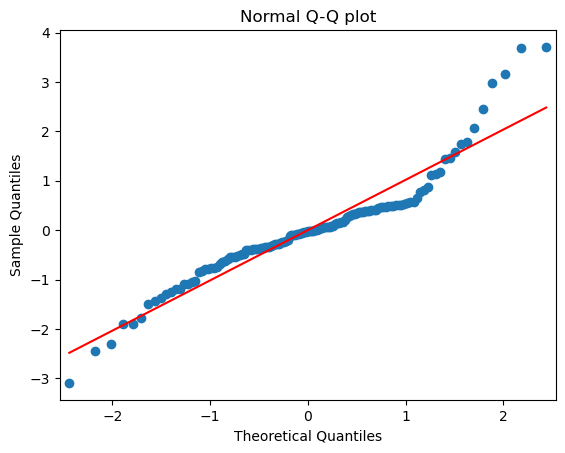

In [31]:
# 2. Normalidad de los residuos
plt.figure(figsize=(8, 6))
sm.qqplot(RL_ajust.resid, line='s')
plt.title('Normal Q-Q plot')
plt.show()

In [32]:
print('Normalidad (shapiro-test):', stats.shapiro(RL_ajust.resid))

Normalidad (shapiro-test): ShapiroResult(statistic=0.9202226400375366, pvalue=7.162051929299196e-07)


<AxesSubplot: ylabel='Count'>

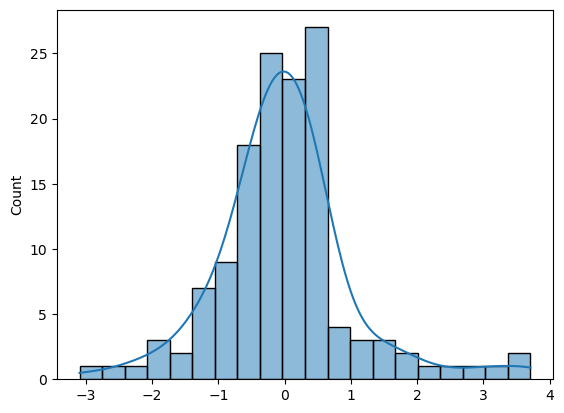

In [33]:
sns.histplot(RL_ajust.resid, kde=True)

##  Model validation

In [34]:
Xtrain

,leak_dia,pressure,flow_pipe
0,3.5,1190,76.752
1,3.5,653,189.540
2,3.5,653,58.729
3,3.5,1016,76.752
4,3.5,1016,189.540
...,...,...,...
130,2.5,653,58.729
131,2.5,1016,76.752
132,2.5,1016,58.729
133,2.5,1016,76.752


In [35]:
ytrain

0      31.966865
1      17.530478
2      16.312640
3      26.121132
4      22.906330
         ...    
130     8.486910
131    14.069389
132    13.965691
133    13.920509
134    15.885361
Name: rod, Length: 135, dtype: float64

In [36]:
rf_tree = RandomForestRegressor(random_state=0, n_estimators=500)
rf_tree.fit(Xtrain,ytrain)
rf_tree_y_pred = rf_tree.predict(Xtrain)
print("Accuracy: {}".format(rf_tree.score(Xtrain,ytrain)))

Accuracy: 0.9932030521560837


In [43]:
# Definir los modelos
models = {
    'PolynomialRegression': Pipeline([
        ('poly', PolynomialFeatures()),
        ('linear', LinearRegression(fit_intercept=True))
    ]),
    'RandomForestRegressor': RandomForestRegressor(),
    'SVR': SVR(kernel='poly'),
    'DecisionTreeRegressor':DecisionTreeRegressor()
}

# Definir los parámetros a ajustar para cada modelo
params = {
    'PolynomialRegression': {'poly__degree': [2,3,4,5]},
    'RandomForestRegressor': {'n_estimators': [100,200,500]},
    'SVR': {'degree':[2,3,4,5]},
    'DecisionTreeRegressor':{}
}

# Se evalúa cada modelo utilizando Grid Search
grid_results = []
best_models = {}
for name, model in models.items():
    #Estimators have a scor method providing a default evaluation criterion for the problem they are designed to solve
    #grid_search = GridSearchCV(model, params[name], cv=5, scoring=['accuracy', 'f1', 'recall'], refit = 'f1') 
    grid_search = GridSearchCV(model, params[name], cv=5) 
    grid_search.fit(Xtrain, ytrain)
    best_models[name] = grid_search.best_estimator_
    grid_results.append({"name": name ,"hyperparameters":grid_search.best_params_, "score": grid_search.best_score_ , "model": grid_search.best_estimator_ })

best_model_report = pd.DataFrame(grid_results).sort_values(by="score", ascending=False)
best_model_report

,name,hyperparameters,score,model
0,PolynomialRegression,{'poly__degree': 3},0.628012,"(PolynomialFeatures(degree=3), LinearRegressio..."
1,RandomForestRegressor,{'n_estimators': 100},-7.309071,"(DecisionTreeRegressor(max_features='auto', ra..."
3,DecisionTreeRegressor,{},-7.334838,DecisionTreeRegressor()
2,SVR,{'degree': 2},-25.260979,"SVR(degree=2, kernel='poly')"


In [38]:
#test

In [39]:
test_rod = pd.read_excel('../data/rod/test_rod.xlsx')
Xtest, ytest = test_rod.drop(columns=["rod", 'leak_flow']), test_rod["rod"] 
#predict = model.predict(Xtest)
#model.score(X,y)

## model export

<AxesSubplot: xlabel='rod', ylabel='leak_flow'>

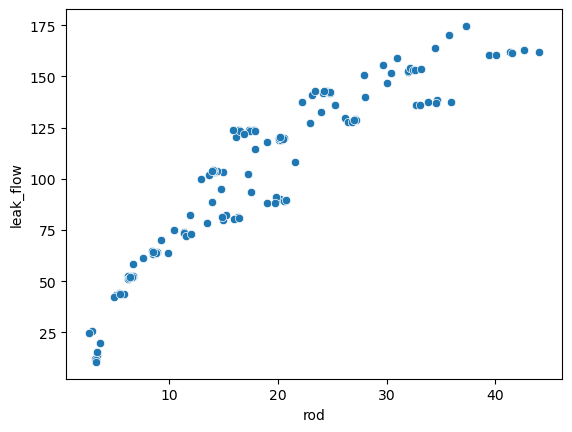

In [40]:
sns.scatterplot(data=rod, x="rod", y="leak_flow")

In [45]:
rod

,leak_dia,leak_distance,pressure,flow_pipe,rod,leak_flow
0,3.5,15.3333,1190,76.752,31.966865,152.279497
1,3.5,7.6667,653,189.540,17.530478,93.460428
2,3.5,7.6667,653,58.729,16.312640,81.364855
3,3.5,7.6667,1016,76.752,26.121132,129.525084
4,3.5,15.3333,1016,189.540,22.906330,127.163212
...,...,...,...,...,...,...
130,2.5,11.5000,653,58.729,8.486910,64.366760
131,2.5,7.6667,1016,76.752,14.069389,104.076787
132,2.5,7.6667,1016,58.729,13.965691,104.119835
133,2.5,11.5000,1016,76.752,13.920509,103.774717


In [48]:
Xtrain_flow

0      31.966865
1      17.530478
2      16.312640
3      26.121132
4      22.906330
         ...    
130     8.486910
131    14.069389
132    13.965691
133    13.920509
134    15.885361
Name: rod, Length: 135, dtype: float64

In [53]:
# Construir el modelo de regresión lineal con todas las variables
Xtrain_flow, ytrain_flow  = rod[["rod"]], rod["leak_flow"]
Xtrain_flow["rod^2"] = Xtrain_flow["rod"]**2

Xtrain_flow = sm.add_constant(Xtrain_flow)
RL_flow = sm.OLS(ytrain_flow, Xtrain_flow).fit()
print(RL_flow.summary())

                            OLS Regression Results                            
Dep. Variable:              leak_flow   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     831.2
Date:                Fri, 08 Mar 2024   Prob (F-statistic):           1.59e-75
Time:                        03:25:10   Log-Likelihood:                -521.80
No. Observations:                 135   AIC:                             1050.
Df Residuals:                     132   BIC:                             1058.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1309      3.308      0.946      0.3

C:\Users\luisl\AppData\Local\Temp\ipykernel_19168\3801147646.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xtrain_flow["rod^2"] = Xtrain_flow["rod"]**2
